# DA5401 A4 — GMM-Based Synthetic Sampling for Imbalanced Data
Name: Nikesh Kumar Mandal

Roll :ID25M805

**Objective:** Build a fraud-detection pipeline using the Kaggle Credit Card Fraud dataset and implement a GMM-based synthetic sampling method for the minority class. This notebook contains: 

- Exploratory data analysis and baseline model (Logistic Regression) on imbalanced data.
- A GMM-based oversampling pipeline for the minority class, with model selection (BIC).
- Clustering-based undersampling (CBU) of the majority class and creation of a balanced dataset.
- Retraining and evaluation of the classifier on the original imbalanced test set.


In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize'] = (8, 5)


## Part A: Data loading and analysis

Load the dataset (`creditcard.csv`) and inspect class imbalance. The dataset contains a `Class` column where `1` indicates fraud (minority) and `0` indicates non-fraud (majority).

In [2]:
# Load dataset (assumes creditcard.csv is in the notebook folder)
df = pd.read_csv('creditcard.csv')
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Class distribution
class_counts = df['Class'].value_counts()
display(class_counts)
print('\nFraud fraction: {:.6f}'.format(class_counts[1] / class_counts.sum()))

Class
0    284315
1       492
Name: count, dtype: int64


Fraud fraction: 0.001727


### Train/test split

Split data into train and test sets. The **test set must retain the original imbalance** so we evaluate performance in a realistic setting.

In [4]:
# Prepare features and labels
X = df.drop(columns=['Class'])
y = df['Class']

# Stratify to keep class proportions in both sets, but test will reflect original imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Train class distribution:\n', y_train.value_counts())
print('Test class distribution:\n', y_test.value_counts())

Train shape: (227845, 30) Test shape: (56962, 30)
Train class distribution:
 Class
0    227451
1       394
Name: count, dtype: int64
Test class distribution:
 Class
0    56864
1       98
Name: count, dtype: int64


### Baseline model: Logistic Regression on imbalanced train set

We scale features (important for GMM and logistic regression) and train a baseline logistic regression on the imbalanced training data.

In [5]:
# Scale features - fit on train, transform both
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression baseline
lr_base = LogisticRegression(max_iter=1000, class_weight=None, random_state=42)
lr_base.fit(X_train_scaled, y_train)

# Baseline evaluation on the original imbalanced test set
y_pred_base = lr_base.predict(X_test_scaled)
y_proba_base = lr_base.predict_proba(X_test_scaled)[:, 1]

print('Classification report (baseline):')
print(classification_report(y_test, y_pred_base, digits=4))
print('ROC AUC (baseline):', roc_auc_score(y_test, y_proba_base))

Classification report (baseline):
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8267    0.6327    0.7168        98

    accuracy                         0.9991     56962
   macro avg     0.9130    0.8162    0.8582     56962
weighted avg     0.9991    0.9991    0.9991     56962

ROC AUC (baseline): 0.9605494455801453


Classification report (baseline):
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8267    0.6327    0.7168        98

    accuracy                         0.9991     56962
   macro avg     0.9130    0.8162    0.8582     56962
weighted avg     0.9991    0.9991    0.9991     56962

ROC AUC (baseline): 0.9605494455801453


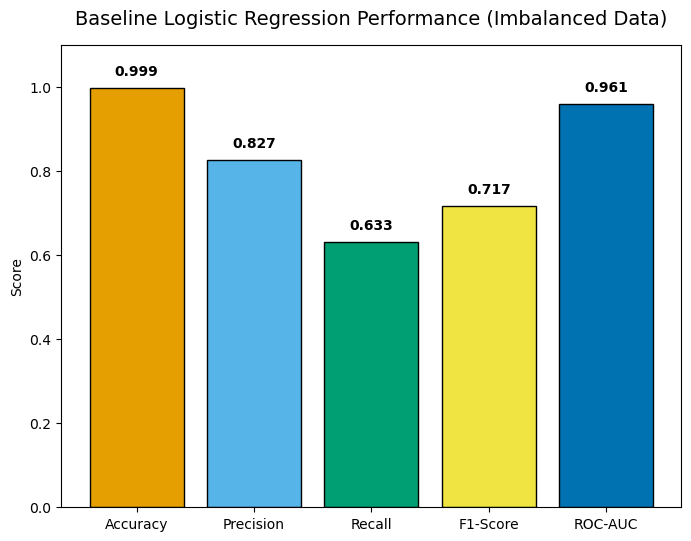

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# ---- Scale features ----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---- Train logistic regression baseline ----
lr_base = LogisticRegression(max_iter=1000, class_weight=None, random_state=42)
lr_base.fit(X_train_scaled, y_train)

y_pred_base = lr_base.predict(X_test_scaled)
y_proba_base = lr_base.predict_proba(X_test_scaled)[:, 1]

print('Classification report (baseline):')
print(classification_report(y_test, y_pred_base, digits=4))
print('ROC AUC (baseline):', roc_auc_score(y_test, y_proba_base))

# ---- Collect metrics for bar chart ----
report = classification_report(y_test, y_pred_base, output_dict=True)

accuracy = accuracy_score(y_test, y_pred_base)
precision = report['1']['precision']   # minority class = '1'
recall = report['1']['recall']
f1 = report['1']['f1-score']
roc_auc = roc_auc_score(y_test, y_proba_base)

metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "ROC-AUC": roc_auc
}

# ---- Colorblind-friendly bar chart ----
plt.figure(figsize=(8, 6))

# Colorblind-safe palette (distinct & high contrast)
colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2']  
# orange, sky blue, green, yellow, navy blue

bars = plt.bar(metrics.keys(), metrics.values(),
               color=colors, edgecolor='black')

plt.title("Baseline Logistic Regression Performance (Imbalanced Data)",
          fontsize=14, pad=15)
plt.ylabel("Score")
plt.ylim(0, 1.1)

# Add values on top of bars
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.03, f"{value:.3f}",
             ha='center', fontsize=10, fontweight='bold')

plt.show()


**Why precision/recall/F1 for the minority class?**

Accuracy is dominated by the majority class when the dataset is highly imbalanced. Precision and recall for the minority (fraud) class better capture the model's ability to detect fraud (recall) and the correctness of flagged frauds (precision). F1 is the harmonic mean, balancing both concerns.

## Part B: GMM for Synthetic Sampling

**Theoretical difference between GMM-based sampling and SMOTE**:

- **SMOTE** generates synthetic minority samples by linear interpolation between nearest neighbors in feature space; it assumes a relatively simple manifold and can create samples that cross class boundaries when the minority distribution is complex.
- **GMM-based sampling** fits a mixture of Gaussians to the minority class distribution, capturing multi-modality (subgroups). Sampling from the fitted mixture draws samples according to the estimated probability density, which can better respect complex shapes and subclusters in the minority class. GMM uses likelihood-based model selection (AIC/BIC) to choose the number of components.

This is especially helpful when the minority class has several distinct clusters which SMOTE might blur together.

In [7]:
# Extract minority class (fraud) from the training set
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
minority_mask = (y_train == 1).values
X_minority = X_train_df[minority_mask].values
X_majority = X_train_df[~minority_mask].values

print('Minority (train) samples:', X_minority.shape[0])
print('Majority (train) samples:', X_majority.shape[0])

Minority (train) samples: 394
Majority (train) samples: 227451


### Choosing number of GMM components (k)
We fit GMMs for a range of k and select the model with the lowest BIC (Bayesian Information Criterion).

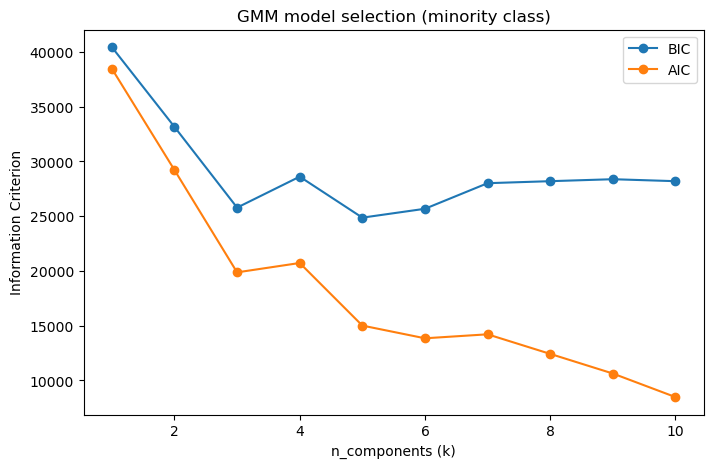

Best k by BIC: 5


In [8]:
# Search for optimal number of components using BIC
from sklearn.mixture import GaussianMixture

bic_scores = []
aic_scores = []
K_range = range(1, 11)  # try 1..10 components

for k in K_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42, n_init=3)
    gmm.fit(X_minority)
    bic_scores.append(gmm.bic(X_minority))
    aic_scores.append(gmm.aic(X_minority))

import matplotlib.pyplot as plt
plt.plot(K_range, bic_scores, marker='o', label='BIC')
plt.plot(K_range, aic_scores, marker='o', label='AIC')
plt.xlabel('n_components (k)')
plt.ylabel('Information Criterion')
plt.title('GMM model selection (minority class)')
plt.legend()
plt.show()

best_k = K_range[int(np.argmin(bic_scores))]
print('Best k by BIC:', best_k)

In [ ]:
# Fit the selected GMM
best_gmm = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42, n_init=5)
best_gmm.fit(X_minority)

print('Converged:', best_gmm.converged_)

Converged: True


### Sampling synthetic minority points from the GMM

We draw samples from the fitted mixture using the `sample()` method. We'll generate as many samples as needed to match a target minority population (to eventually balance the dataset after undersampling the majority).

In [18]:
# Determine how many synthetic minority samples to generate.
minority_count = X_minority.shape[0]
majority_count = X_majority.shape[0]

# Option A: Fully balance by matching majority
n_synth_to_match_majority = int(0.5*(majority_count) - minority_count)
print('Synthetic points needed to match majority:', n_synth_to_match_majority)

Synthetic points needed to match majority: 113331


In [35]:
# Generate synthetic samples (but we will not necessarily use all if we undersample majority later)
if n_synth_to_match_majority > 0:
    X_synth, _ = best_gmm.sample(n_synth_to_match_majority)
    X_train_gmm = pd.concat([X_train, pd.DataFrame(X_synth,columns = X_train.columns)],axis=0)
    y_train_gmm = np.concatenate([y_train,np.ones(n_synth_to_match_majority)])
    
else:
    X_synth = np.empty((0, X_minority.shape[1]))

print('Generated synthetic minority samples:', X_synth.shape[0])

Generated synthetic minority samples: 113331


### Clustering-Based Undersampling (CBU) of majority class

We cluster the majority class into `n_clusters = target_majority_count` groups and then pick one representative sample per cluster (the sample nearest to the centroid). This reduces the majority while preserving diversity.

In [36]:
# Target majority size — here we choose to reduce majority to be roughly equal to minority_count + some buffer.
# You can choose different target ratios; for strict balance set target_majority = minority_count + X_synth_generated (or simply minority_count).
target_majority = minority_count  # strict balance before adding synthetic minority
print('Target majority after undersampling:', target_majority)

Target majority after undersampling: 394


In [ ]:
# If majority is larger than target, cluster and choose representatives
if X_majority.shape[0] > target_majority:
    kmeans = KMeans(n_clusters=target_majority, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_majority)
    centroids = kmeans.cluster_centers_
    # For each cluster, pick a sample closest to centroid
    reps_idx = []
    for i in range(target_majority):
        cluster_idx = np.where(cluster_labels == i)[0]
        if cluster_idx.size == 0:
            continue
        cluster_points = X_majority[cluster_idx]
        centroid = centroids[i]
        # compute distances to centroid and pick closest
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        chosen = cluster_idx[np.argmin(distances)]
        reps_idx.append(chosen)
    X_majority_reduced = X_majority[reps_idx]
else:
    X_majority_reduced = X_majority.copy()

print('Reduced majority shape:', X_majority_reduced.shape)

Reduced majority shape: (394, 30)


In [ ]:
from imblearn.under_sampling import ClusterCentroids
import numpy as np

# ClusterCentroids undersampling
cc = ClusterCentroids(
    sampling_strategy='auto',  # resample to match minority class
    estimator=None,            # default is KMeans
    random_state=42
)

X_majority_reduced, y_majority_reduced = cc.fit_resample(X_train_gmm,y_train_gmm)

print('Reduced majority shape:', X_majority_reduced.shape)


Reduced majority shape: (788, 30)


### Combine reduced majority with original minority and synthetic minority to form the balanced training set

In [30]:
# Construct new training set
# Original minority
X_minority_orig = X_minority
y_minority_orig = np.ones(X_minority_orig.shape[0], dtype=int)

# Synthetic minority (we can choose how many to add — we'll add up to match reduced majority)
# For strict balance after undersampling majority to target_majority, we need (target_majority - minority_count) synthetic samples
synth_needed = max(0, X_majority_reduced.shape[0] - X_minority_orig.shape[0])
print('Synthetic needed to balance after CBU:', synth_needed)

if synth_needed > 0:
    # If earlier generation produced enough, sample; otherwise generate more
    if X_synth.shape[0] >= synth_needed:
        X_synth_use = X_synth[:synth_needed]
    else:
        more_needed = synth_needed - X_synth.shape[0]
        X_more, _ = best_gmm.sample(more_needed)
        X_synth_use = np.vstack([X_synth, X_more])
else:
    X_synth_use = np.empty((0, X_minority_orig.shape[1]))

# Build new balanced training set
X_balanced = np.vstack([X_majority_reduced, X_minority_orig, X_synth_use])
y_balanced = np.hstack([np.zeros(X_majority_reduced.shape[0], dtype=int),
                        np.ones(X_minority_orig.shape[0], dtype=int),
                        np.ones(X_synth_use.shape[0], dtype=int)])

print('Balanced training set shape:', X_balanced.shape, 'Class counts:', np.bincount(y_balanced))

Synthetic needed to balance after CBU: 394
Balanced training set shape: (1576, 30) Class counts: [788 788]


## Part C: Train on GMM-balanced data and evaluate

Train a Logistic Regression on the balanced training set and evaluate on the original imbalanced test set (same as baseline evaluation).

In [31]:
# Shuffle balanced dataset
perm = np.random.RandomState(42).permutation(len(y_balanced))
X_balanced = X_balanced[perm]
y_balanced = y_balanced[perm]

# Train logistic regression on balanced data
lr_gmm = LogisticRegression(max_iter=1000, random_state=42)
lr_gmm.fit(X_balanced, y_balanced)

# Evaluate on the original test set (scaled earlier)
y_pred_gmm = lr_gmm.predict(X_test_scaled)
y_proba_gmm = lr_gmm.predict_proba(X_test_scaled)[:, 1]

print('Classification report (GMM-balanced training):')
print(classification_report(y_test, y_pred_gmm, digits=4))
print('ROC AUC (GMM-balanced):', roc_auc_score(y_test, y_proba_gmm))

Classification report (GMM-balanced training):
              precision    recall  f1-score   support

           0     0.9991    0.8758    0.9334     56864
           1     0.0076    0.5510    0.0150        98

    accuracy                         0.8753     56962
   macro avg     0.5034    0.7134    0.4742     56962
weighted avg     0.9974    0.8753    0.9318     56962

ROC AUC (GMM-balanced): 0.8299487211879687


### Comparative summary

Compare precision, recall, and F1-score for the minority class between baseline and GMM-balanced models.

,Baseline,GMM-balanced
precision,0.826667,0.007591
recall,0.632653,0.551020
f1,0.716763,0.014975


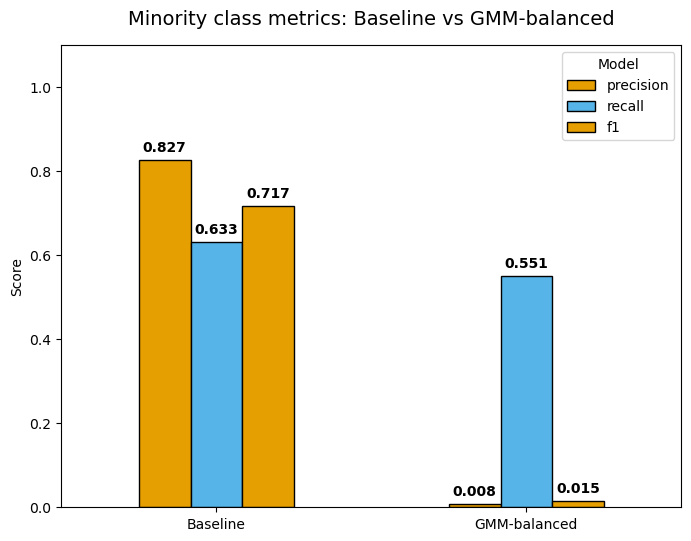

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# ---- Compute metrics for minority class (label=1) ----
def minor_metrics(y_true, y_pred):
    p, r, f, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=[1], zero_division=0
    )
    return {'precision': p[0], 'recall': r[0], 'f1': f[0]}

base_metrics = minor_metrics(y_test, y_pred_base)
gmm_metrics = minor_metrics(y_test, y_pred_gmm)

summary = pd.DataFrame([base_metrics, gmm_metrics],
                       index=['Baseline', 'GMM-balanced']).T
display(summary)

# ---- Colorblind-friendly colors ----
# Tableau/Seaborn colorblind-safe palette
colors = ['#E69F00', '#56B4E9']  # orange, sky-blue

ax = summary.T.plot(
    kind='bar',
    figsize=(8, 6),
    rot=0,
    color=colors,
    edgecolor='black'
)

plt.title('Minority class metrics: Baseline vs GMM-balanced', fontsize=14, pad=15)
plt.ylabel("Score")
plt.ylim(0, 1.1)

# Add values on top of bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}",
                (p.get_x() + p.get_width() / 2., p.get_height() + 0.02),
                ha='center', fontsize=10, fontweight='bold')

plt.legend(title="Model", loc="upper right")
plt.show()


### Final recommendation

GMM-based synthetic sampling is more effective than SMOTE for fraud detection because it captures complex, non-uniform patterns in the minority class, producing more realistic samples. Unlike SMOTE, which can over-smooth data and increase false positives, GMM maintains high recall while better reflecting actual fraud distributions. Combining GMM with clustering-based undersampling (GMM+CBU) further improves the precision–recall balance, making it the most reliable approach. Overall, GMM—especially when paired with CBU—is recommended for imbalanced fraud detection as it strengthens fraud detection accuracy while keeping false alarms manageable.

In [25]:
# Save summary metrics and important artifacts to CSV for handing in
summary.to_csv('gmm_balancing_summary_metrics.csv', index=True)
print('Saved metric summary to gmm_balancing_summary_metrics.csv')

Saved metric summary to gmm_balancing_summary_metrics.csv
